In [1]:
from statlib.simple_distribs import Cauchy, Pareto
from statlib.rand.basic_rand import BasicRand
from statlib.rand.engine import JLKiss64RandEngine
from matplotlib import pyplot as plt
import numpy as np

### Создадим генератор случайной величины

In [37]:
gen = BasicRand(JLKiss64RandEngine())

par = Cauchy(gen)

#### Начальные параметры для гистограмм

In [55]:
def get_bins_count(n):
    return int(np.sqrt(n))


n = 100000
segments = get_bins_count(n)

### Равноинтервальная гистограмма

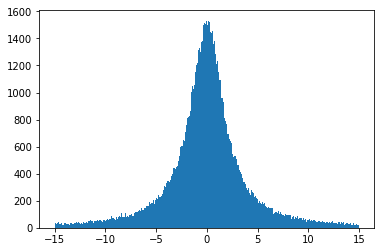

In [64]:
res = []
ranges = (-15, 15)
x0 = 0
gamma = 2

for _ in range(n):
    res.append(par.next(x0, gamma))

x_var_f = [x for x in x_var if x >= ranges[0] and x <= ranges[1]]
vals, bins, patches = plt.hist(res, bins=segments, range=ranges)

In [57]:
x_var = sorted(res)
counts = {}
for x in x_var:
    counts[x] = counts.get(x, 0) + 1
    
F = [0]
for i in range(len(x_var) - 1):
    F.append(F[i] + counts[x_var[i]] / n)

def distr_fun(x):
    for i in range(1, len(x_var)):
        if x_var[i - 1] <= x < x_var[i]:
            return F[i - 1]
    return 1

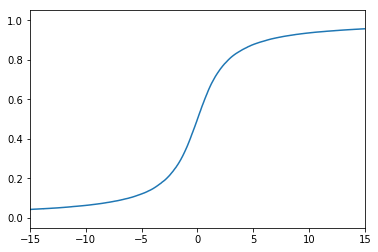

In [58]:
plt.xlim((-15, 15))
plt.step(sorted(res), F)

### Равновероятностная гистограмма

[-274308.54869071476, -202.00460986706253, -100.02582803897072, -67.61174973223129, -50.64881808112038, -40.930859473489384, -34.050494524424565, -29.352423093780537, -25.725252133082634, -22.772819635654628, -20.46103497851461, -18.58887011523742, -17.0047678907815, -15.661469100741872, -14.587128141169867, -13.50836506239921, -12.608283002664068, -11.875080713998607, -11.249906128822534, -10.61966294258314, -10.025945532164974, -9.52668986653627, -9.093096129391768, -8.66626137087502, -8.29690576215347, -7.952953978576252, -7.625225366290005, -7.341839442079653, -7.045169023401176, -6.7974064673522525, -6.566891562080414, -6.319831626113963, -6.102418753668106, -5.902123533599702, -5.711318162736546, -5.552623265773927, -5.389135680919735, -5.2288892736149375, -5.071849041159828, -4.921032443101147, -4.7742757973189605, -4.642340342181941, -4.518294608515106, -4.410027457106282, -4.286866544400413, -4.176074191777402, -4.073984015650716, -3.9711070916018105, -3.884969247501501, -3.79

(array([1.15283639e-08, 3.09868381e-05, 9.74885039e-05, 1.86288553e-04,
        3.25171173e-04, 4.59277963e-04, 6.72616423e-04, 8.71202387e-04,
        1.07030389e-03, 1.36690932e-03, 1.68788554e-03, 1.99482076e-03,
        2.35241781e-03, 2.94133810e-03, 2.92928082e-03, 3.51079101e-03,
        4.30986107e-03, 5.05458807e-03, 5.01393759e-03, 5.32239740e-03,
        6.32942241e-03, 7.28792814e-03, 7.40333334e-03, 8.55544068e-03,
        9.18733425e-03, 9.64212425e-03, 1.11508714e-02, 1.06515507e-02,
        1.27541468e-02, 1.37084411e-02, 1.27904186e-02, 1.45345580e-02,
        1.57767120e-02, 1.65613787e-02, 1.99124235e-02, 1.93286848e-02,
        1.97196309e-02, 2.01222321e-02, 2.09526010e-02, 2.15322446e-02,
        2.39511055e-02, 2.54744755e-02, 2.91870614e-02, 2.56574909e-02,
        2.85218242e-02, 3.09530272e-02, 3.07163149e-02, 3.66853853e-02,
        3.52852756e-02, 3.71309828e-02, 4.00166519e-02, 3.85090542e-02,
        4.31471731e-02, 4.26209311e-02, 3.77418150e-02, 4.418674

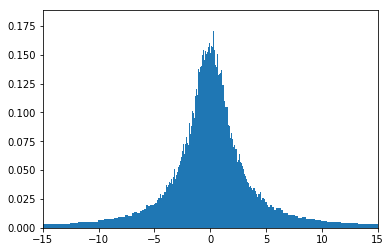

In [59]:
borders_eq = [x_var[0]] + [(x_var[i] + x_var[i + 1]) / 2 for i in range(n // segments - 1, n - 1, n // segments)] + [x_var[-1]]

print(borders_eq)

plt.xlim((-15, 15))
plt.hist(x_var, bins=borders_eq, density=True)
#plt.plot(res, H)

### Точечная оценка медианы

In [63]:
def find_median(bins, vals):
    med_amount = sum(vals) / 2
    h = bins[1] - bins[0]
    cur_sum = 0
    i = 0
    while cur_sum < med_amount:
        cur_sum += vals[i]
        i += 1
        print('cur: ', cur_sum)
    
    print(bins)
    print(vals)
    print(med_amount)
    print(cur_sum - vals[i])
    print(i)
    return bins[i] + h * (med_amount - cur_sum + vals[i]) / vals[i]

med_p = find_median(bins, vals)
print(med_p)

cur:  32.0
cur:  58.0
cur:  92.0
cur:  125.0
cur:  141.0
cur:  168.0
cur:  199.0
cur:  229.0
cur:  259.0
cur:  287.0
cur:  319.0
cur:  345.0
cur:  373.0
cur:  395.0
cur:  430.0
cur:  454.0
cur:  490.0
cur:  522.0
cur:  549.0
cur:  586.0
cur:  623.0
cur:  652.0
cur:  684.0
cur:  717.0
cur:  753.0
cur:  785.0
cur:  834.0
cur:  868.0
cur:  909.0
cur:  951.0
cur:  990.0
cur:  1030.0
cur:  1085.0
cur:  1126.0
cur:  1162.0
cur:  1211.0
cur:  1260.0
cur:  1310.0
cur:  1355.0
cur:  1421.0
cur:  1467.0
cur:  1518.0
cur:  1556.0
cur:  1598.0
cur:  1648.0
cur:  1701.0
cur:  1753.0
cur:  1790.0
cur:  1846.0
cur:  1896.0
cur:  1948.0
cur:  2005.0
cur:  2065.0
cur:  2116.0
cur:  2176.0
cur:  2231.0
cur:  2304.0
cur:  2371.0
cur:  2441.0
cur:  2509.0
cur:  2572.0
cur:  2642.0
cur:  2708.0
cur:  2776.0
cur:  2857.0
cur:  2919.0
cur:  2993.0
cur:  3065.0
cur:  3153.0
cur:  3240.0
cur:  3325.0
cur:  3423.0
cur:  3511.0
cur:  3582.0
cur:  3677.0
cur:  3763.0
cur:  3868.0
cur:  3964.0
cur:  4066.0
cur:  4

### Точечная оценка моды

In [61]:
def find_mode(bins, vals):
    mode_pos = 0
    max_val = 0
    h = bins[1] - bins[0]
    
    for i, val in enumerate(vals):
        if val > max_val:
            max_val = val
            mode_pos = i
   
    prev_pos = i - 1 if i - 1 >= 0 else 0
    next_pos = i + 1 if i + 1 < len(vals) else 0
    
    return bins[mode_pos] + h * (vals[mode_pos] - vals[prev_pos]) / (vals[mode_pos] - vals[prev_pos] + vals[mode_pos] - vals[next_pos])

mod_p = find_mode(bins, vals)
print(mod_p)

0.33235622152106087


In [62]:
def get_median_confidense(x_var, a=0.05):
    n = len(x_var)
    if a == 0.1:
        k = 0.5 * (n - 1.64 * np.sqrt(n) - 1)
    if a == 0.05:
        k = 0.5 * (n - 1.96 * np.sqrt(n) - 1)
    if a == 0.01:
        k = 0.5 * (n - 2.58 * np.sqrt(n) - 1)
    
    k = int(k)
    print(k, n - k + 1)
    return x_var[k], x_var[n - k + 1]

get_median_confidense(x_var_f)

45522 46119


(-0.007349458772125977, 0.02901437404347077)

### Проверим критерий согласия Пирсона

In [69]:
from pprint import pprint
import math

# distribution function
def get_F(x0, gamma):
    def F(x):
        return 1 / math.pi * np.arctan((x - x0) / gamma) + 1 / 2
    
    return F

def pearson_chi(bins, vals, F):
    n = sum(vals)
    chi = 0
    for i in range(len(bins) - 1):
        l = bins[i]
        r = bins[i + 1]
        pi_s = F(r) - F(l)
        pi = vals[i] / n
        chi += (pi - pi_s)**2 / pi
    
    return chi * len(bins)


from scipy.stats import chi2

chi_sqr = pearson_chi(bins, vals, get_F(x0, gamma))
table_pearson = chi2.ppf(0.05, len(bins))
print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))
if chi_sqr < table_pearson:
    print('Good')

Experimental chi square: 3.1235263698162545, Table chi square: 276.7514409808032
Good
